## Load NDE and D2RL Processed Data

In [ ]:
import numpy as np
NDE_weight_result_path = "../../processed_data/NDE/NDE_crash_result.npy"
D2RL_weight_result_path = "../../processed_data/D2RL/weight_result.npy"
NADE_weighted_result_list = np.load(D2RL_weight_result_path)
NDE_weighted_result_list = np.load(NDE_weight_result_path)

In [ ]:
np.random.seed(1)
print("NDE episode number:", NDE_weighted_result_list[1])
print("NADE episode number:", len(NADE_weighted_result_list))
print("NDE crash number:", NDE_weighted_result_list[0])
print("NADE crash number:", np.sum(NADE_weighted_result_list>0))

NDE episode number: 234212252
NADE episode number: 3141500
NDE crash number: 37
NADE crash number: 9952


In [ ]:
crash_id_list = np.random.randint(0, NDE_weighted_result_list[1], size=NDE_weighted_result_list[0])

## Analyse the processed D2RL and NDE Data

In [ ]:
# D2RL crash rate and RHW calculation
def plot_crash_and_CI_return(weighted_result_list):
    # print(len())
    from scipy.stats import norm
    import pandas as pd 
    confidence_interval = 0.1
    z = norm.ppf(1-confidence_interval/2)
    # weighted_result_list = weighted_result_list[3000]
    original_result = pd.Series(weighted_result_list)
    crash_mean_result = original_result.rolling(len(original_result), min_periods=1).mean()
    unit_std_result = original_result.rolling(len(original_result), min_periods=1).std()
    half_CI = z*unit_std_result/(np.sqrt(np.array(range(1, len(original_result)+1)))*crash_mean_result)
    half_CI_numpy = half_CI.to_numpy()
    crash_mean_result_numpy = crash_mean_result.to_numpy()
    return crash_mean_result_numpy, half_CI_numpy, np.where(half_CI_numpy > 0.3)[0][-1]

In [ ]:
# NDE crash rate and RHW calculation
from tqdm import tqdm
def plot_crash_and_CI_NDE(weighted_result_list_length, crash_id_list):
    # print(len())
    from scipy.stats import norm
    confidence_interval = 0.1
    total_plot_points = 1000
    plot_interval, step_length = np.linspace(1, weighted_result_list_length, total_plot_points, retstep=True, dtype=int)
    z = norm.ppf(1-confidence_interval/2)
    crash_mean_result_numpy = []
    half_CI_numpy = []
    for interval in tqdm(plot_interval):
        crash_rate_tmp, half_ci_tmp = get_crash_rate_and_half_CI(crash_id_list, interval)
        crash_mean_result_numpy.append(crash_rate_tmp)
        half_CI_numpy.append(half_ci_tmp)
    half_CI_numpy = np.array(half_CI_numpy)
    return np.array(crash_mean_result_numpy), half_CI_numpy, np.where(half_CI_numpy > 0.3)[0][-1], step_length

def get_crash_rate_and_half_CI(crash_id_list, interval):
    from scipy.stats import norm
    confidence_interval = 0.1
    z = norm.ppf(1-confidence_interval/2)
    total_crash_num = 0
    total_crash_num = np.sum(np.array(crash_id_list) < interval)
    crash_rate_tmp = float(total_crash_num)/float(interval)
    std_tmp = np.sqrt((crash_rate_tmp**2 * (interval-total_crash_num) + (1-crash_rate_tmp)**2 * total_crash_num)/interval)
    half_ci_tmp = z * std_tmp / (np.sqrt(interval) * crash_rate_tmp)
    return crash_rate_tmp, half_ci_tmp
    

In [ ]:
data1_raw, data1_CI_raw, data1_convergence_number, NDE_step_length = plot_crash_and_CI_NDE(NDE_weighted_result_list[1], crash_id_list)
data1, data1_CI = data1_raw, data1_CI_raw

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\print\AppData\Local\Temp\ipykernel_33760\4158332160.py:26: RuntimeWarning: invalid value encountered in double_scalars
  half_ci_tmp = z * std_tmp / (np.sqrt(interval) * crash_rate_tmp)
100%|██████████| 1000/1000 [00:00<00:00, 7407.50it/s]


In [ ]:

data2_raw, data2_CI_raw, data2_convergence_number = plot_crash_and_CI_return(NADE_weighted_result_list)

In [ ]:
data2, data2_CI = data2_raw[::1000][:2400], data2_CI_raw[::1000][:2400]

## NDE and D2RL Crash Rate Figure

NDE Ground Truth: 1.5797636410583677e-07
1.6037021331988827e-07
[8. 8.]


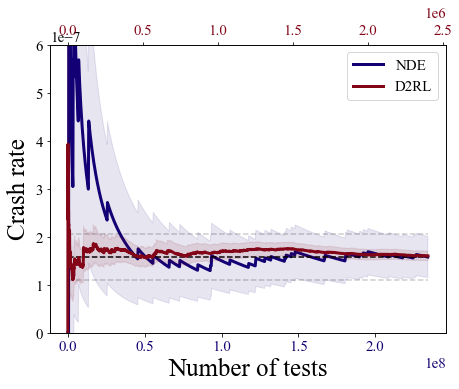

In [ ]:
import matplotlib
import matplotlib.pyplot as plt 
font = {'family' : 'Times New Roman',
        'size'   : 15}
plt.rc('font', **font)
color_blue = '#130074' # deep blue
color_red = (131/255,5/255,24/255)

from mpl_toolkits.axes_grid1 import Divider, Size
fig = plt.figure(figsize=(8,8))
color_red = (131/255,5/255,24/255)
h = [Size.Fixed(1.0), Size.Fixed(5.5)]
v = [Size.Fixed(1.0), Size.Fixed(4)]
divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),
                  axes_locator=divider.new_locator(nx=1, ny=1))



color = color_blue
label_flag = True
if label_flag:
    ax1.set_xlabel('Number of tests', fontsize=25)
    ax1.set_ylabel('Crash rate', fontsize=25)

t1 = np.array(range(len(data1))) * NDE_step_length
m1 = ax1.plot(t1, data1, color=color, linewidth=3, label="NDE")
ax1.fill_between(t1, (1-data1_CI)*data1, (1+data1_CI)*data1, alpha=0.1, color=color)

# plt.legend()
ax1.tick_params(axis='x', labelcolor=color)
ax1.ticklabel_format(style='sci', scilimits=(-1,2), axis='x')

true_value = data1[-1]
print("NDE Ground Truth:", true_value)
ax1.plot(t1, [true_value]*len(data1), "k--")
ax1.plot(t1, [true_value*1.3]*len(data1), "k--",alpha=0.2)
ax1.plot(t1, [true_value*0.7]*len(data1), "k--",alpha=0.2)
ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
print(data2[-1])
color = color_red

t2 = np.array(range(len(data2))) * 1000
m2 = ax2.plot(t2, data2, color=color, linewidth=3, label="D2RL")
ax2.fill_between(t2, (1-data2_CI)*data2, (1+data2_CI)*data2, alpha=0.1, color=color_red)
ax2.tick_params(axis='x', labelcolor=color)
ax2.ticklabel_format(style='sci', scilimits=(-1,2), axis='x')
m = m1+m2
m_label = [tmp.get_label() for tmp in m]
ax1.legend(m, m_label)
plt.ylim(0, 0.6e-6)
print(fig.get_size_inches())
plt.savefig("d2rl_vs_NDE_crash_rate.svg", bbox_inches = 'tight')
plt.savefig("d2rl_vs_NDE_crash_rate.pdf", bbox_inches = 'tight')
plt.savefig("d2rl_vs_NDE_crash_rate.png", bbox_inches = 'tight', dpi=400)

## NDE and D2RL Relarive Half Width (RHW) Figure

[8. 8.]


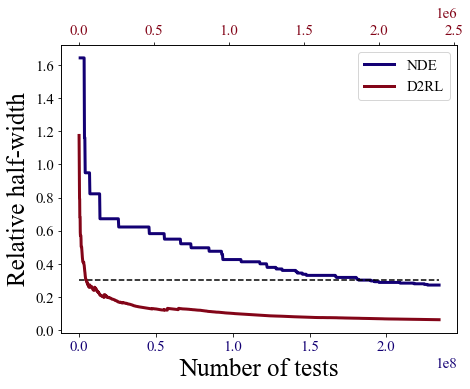

In [ ]:
# t = np.array(range(len(data2_CI)))

from mpl_toolkits.axes_grid1 import Divider, Size
fig = plt.figure(figsize=(8,8))

# The first items are for padding and the second items are for the axes.
# sizes are in inch.
h = [Size.Fixed(1.0), Size.Fixed(5.5)]
v = [Size.Fixed(1.0), Size.Fixed(4)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
# The width and height of the rectangle are ignored.

ax1 = fig.add_axes(divider.get_position(),
                  axes_locator=divider.new_locator(nx=1, ny=1))

color = color_blue
label_flag = True
if label_flag:
    ax1.set_xlabel('Number of tests', fontsize=25)
    ax1.set_ylabel('Relative half-width', fontsize=25)
t1 = np.array(range(len(data1))) * NDE_step_length

m1 = ax1.plot(t1, data1_CI, color=color, linewidth=3, label="NDE")
ax1.tick_params(axis='x', labelcolor=color)
ax1.ticklabel_format(style='sci', scilimits=(-1,2), axis='x')

ax1.plot(t1, [0.3]*len(t1), "k--")
ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

color = color_red
ax2.set_ylabel('Variance', color=color)  # we already handled the x-label with ax1

t2 = np.array(range(len(data2_CI))) * 1000
m2 = ax2.plot(t2, data2_CI, color=color, linewidth=3, label="D2RL")
# plt.yscale("log")
# ax2.fill_between(t, (smooth_path-path_deviation)[0], (smooth_path+path_deviation)[0], color=color, alpha=.1)
ax2.tick_params(axis='x', labelcolor=color)
ax2.ticklabel_format(style='sci', scilimits=(-1,2), axis='x')
m = m1+m2
m_label = [tmp.get_label() for tmp in m]
ax1.legend(m, m_label)
# fig.set_size_inches(6,5)
# fig.tight_layout()  # otherwise the right y-label is slightly clipped
print(fig.get_size_inches())
plt.savefig("d2rl_vs_NDE_RHW.svg", bbox_inches = 'tight')
plt.savefig("d2rl_vs_NDE_RHW.pdf", bbox_inches = 'tight')
plt.savefig("d2rl_vs_NDE_RHW.png", bbox_inches = 'tight', dpi=400)

## Bootstrap Analysis

In [ ]:
from tqdm import tqdm
drl_CI_number_list = []
for i in tqdm(range(1000)):
    weighted_result_list = np.random.choice(NADE_weighted_result_list,int(4e5))
    crash_mean, CI, convergence_number = plot_crash_and_CI_return(weighted_result_list)
    drl_CI_number_list.append(convergence_number)

100%|██████████| 1000/1000 [01:37<00:00, 10.23it/s]


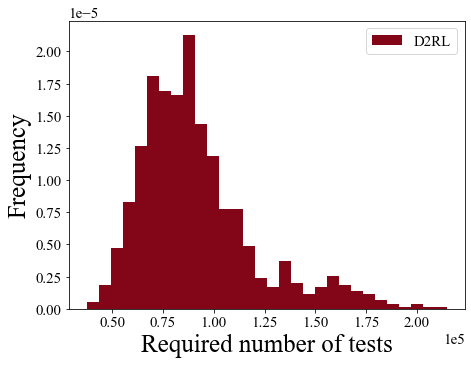

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'Times New Roman',
        'size'   : 15}
plt.rc('font', **font)
from mpl_toolkits.axes_grid1 import Divider, Size
fig = plt.figure(figsize=(8,8))
color_red = (131/255,5/255,24/255)
# The first items are for padding and the second items are for the axes.
# sizes are in inch.
h = [Size.Fixed(1.0), Size.Fixed(5.5)]
v = [Size.Fixed(1.0), Size.Fixed(4)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
# The width and height of the rectangle are ignored.

ax1 = fig.add_axes(divider.get_position(),
                  axes_locator=divider.new_locator(nx=1, ny=1))

ax1.hist(drl_CI_number_list, bins=30, density=True, label = "D2RL", color=color_red)
label_flag = True
if label_flag:
        plt.xlabel("Required number of tests", fontsize=25)
        plt.ylabel("Frequency", fontsize=25)
plt.ticklabel_format(style='sci', scilimits=(-1,2), axis='x')
ax1.legend()
plt.savefig("d2rl_bootstrap.svg", bbox_inches = 'tight')
plt.savefig("d2rl_bootstrap.png", bbox_inches = 'tight', dpi=400)
plt.savefig("d2rl_bootstrap.pdf", bbox_inches = 'tight')